In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import os 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,plot_xgb_feature_importance


In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

################################# 数据 读取-处理 开始#################################
sheet = pd.read_excel('data_input/主焦煤价格-临汾拟合残差-焦煤煤矿+港口库存.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
sheet = sheet.rename(columns={'秦皇岛动力煤价格Q5500': '秦皇岛动力煤价格'})
last_day = sheet['主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存'].last_valid_index()

sheet.columns  

Index(['主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存', '焦煤竞拍流拍率/60DMA', 'WTI原油期货价格', '秦皇岛动力煤价格',
       '螺纹总库存超季节性/3年', '天然气TTF连1价格', '焦煤上游总库存/4WMANon-Trend/F0.1'],
      dtype='object')

In [4]:
# 尝试多个可能的文件路径
file_paths2 = [
    os.path.expanduser("~/Desktop/X-BASE/动力煤/eta/秦皇岛动力煤价格_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/动力煤/eta/秦皇岛动力煤价格_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/Horizon-Insights/动力煤/eta/秦皇岛动力煤价格_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/动力煤/eta/秦皇岛动力煤价格_合并数据.xlsx")
]

file_path2 = None
for path in file_paths2:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path2 = path
        break

if file_path2 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
    sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
    sheet2 = sheet2.drop(columns=['真实值'])
    sheet2 = sheet2.dropna()
    sheet2 = sheet2.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet2.head()

,Date,预测值
24,2025-10-29,781.9
23,2025-10-30,781.9
22,2025-10-31,781.5
21,2025-11-03,782.0
20,2025-11-04,777.5


In [5]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['秦皇岛动力煤价格'] = sheet_daily['秦皇岛动力煤价格'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])


# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [6]:
################################# 处理数据 让他们更适合 用来预测之后一个月的数据  #################################
future_data_30days = sheet[sheet.index > last_day]
# 生成周五数据,6周的数据
target_days = pd.date_range(start=last_day + pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day + pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail() 

,主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存,焦煤竞拍流拍率/60DMA,WTI原油期货价格,秦皇岛动力煤价格,螺纹总库存超季节性/3年,天然气TTF连1价格,焦煤上游总库存/4WMANon-Trend/F0.1
2025-11-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
sheet.columns

Index(['主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存', '焦煤竞拍流拍率/60DMA', 'WTI原油期货价格', '秦皇岛动力煤价格',
       '螺纹总库存超季节性/3年', '天然气TTF连1价格', '焦煤上游总库存/4WMANon-Trend/F0.1'],
      dtype='object')

In [8]:
################################# 处理缺失值 #################################
fill_methods = {
'秦皇岛动力煤价格':'interpolate', 
'焦煤上游总库存/4WMANon-Trend/F0.1':'interpolate',
'螺纹总库存超季节性/3年':'interpolate', 
'WTI原油期货价格':'interpolate', 
'焦煤竞拍流拍率/60DMA':'interpolate',
'天然气TTF连1价格':'interpolate', 
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, '主焦煤价格/临汾拟合残差/焦煤上游总库存'] = sheet.loc[:last_day, '主焦煤价格/临汾拟合残差/焦煤上游总库存'].interpolate(method='linear')

#################################  因子处理  #################################
                                                         
sheet['焦煤上游总库存/4WMANon-Trend/F0.1_提前20天'] = sheet['焦煤上游总库存/4WMANon-Trend/F0.1'].shift(20)
sheet['螺纹总库存超季节性/3年_提前25天'] = sheet['螺纹总库存超季节性/3年'].shift(25)
sheet['焦煤竞拍流拍率/60DMA_提前40天'] = sheet['焦煤竞拍流拍率/60DMA'].shift(40)
sheet['天然气TTF连1价格_提前20天'] = sheet['天然气TTF连1价格'].shift(21)    
sheet['WTI原油期货价格_提前30天'] = sheet['WTI原油期货价格'].shift(31)



sheet['焦煤上游总库存/4WMANon-Trend/F0.1_提前20天_逆序'] = reverse_column(sheet, '焦煤上游总库存/4WMANon-Trend/F0.1_提前20天')
sheet['焦煤竞拍流拍率/60DMA_提前40天_逆序'] = reverse_column(sheet, '焦煤竞拍流拍率/60DMA_提前40天')

'''
sheet['美国经济惊喜指数_提前45天_2023-04-01'] = np.where(
    sheet.index >= pd.Timestamp('2023-04-01'),
    sheet['美国经济惊喜指数_提前45天'],
    np.nan
)
sheet['COMEX黄金价格Non-Trend/F0.02_提前50天_2023-12-01'] = np.where(
    sheet.index >= pd.Timestamp('2023-12-01'),
    sheet['COMEX黄金价格Non-Trend/F0.02_提前50天'],
    np.nan
)
'''
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存'].notna())          
]

################################# 数据 读取-处理 结束 #################################

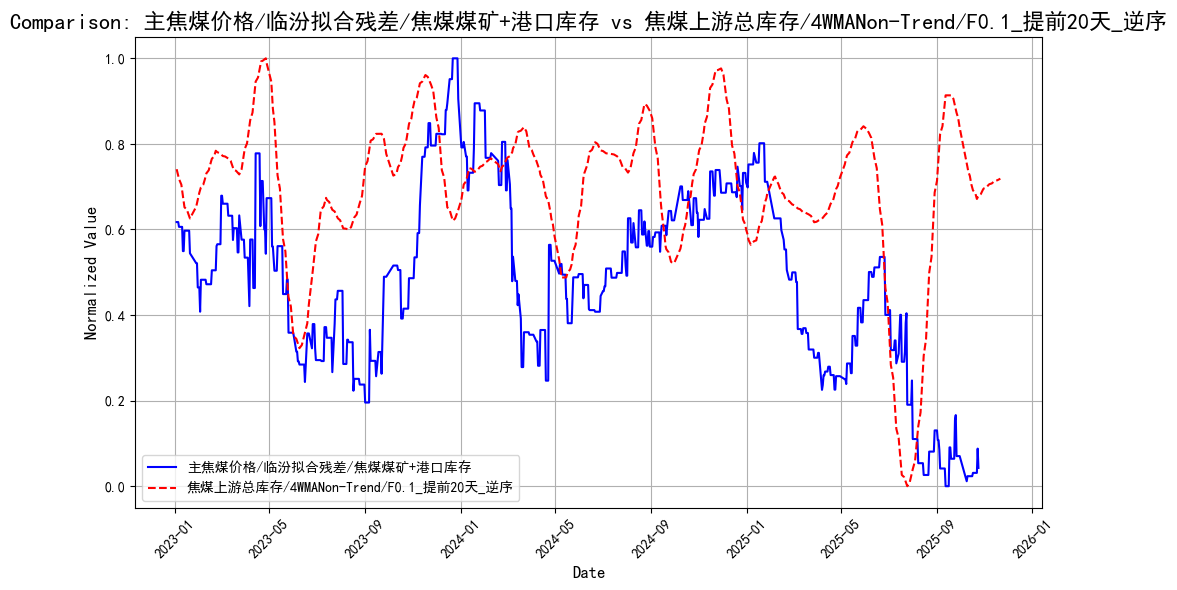

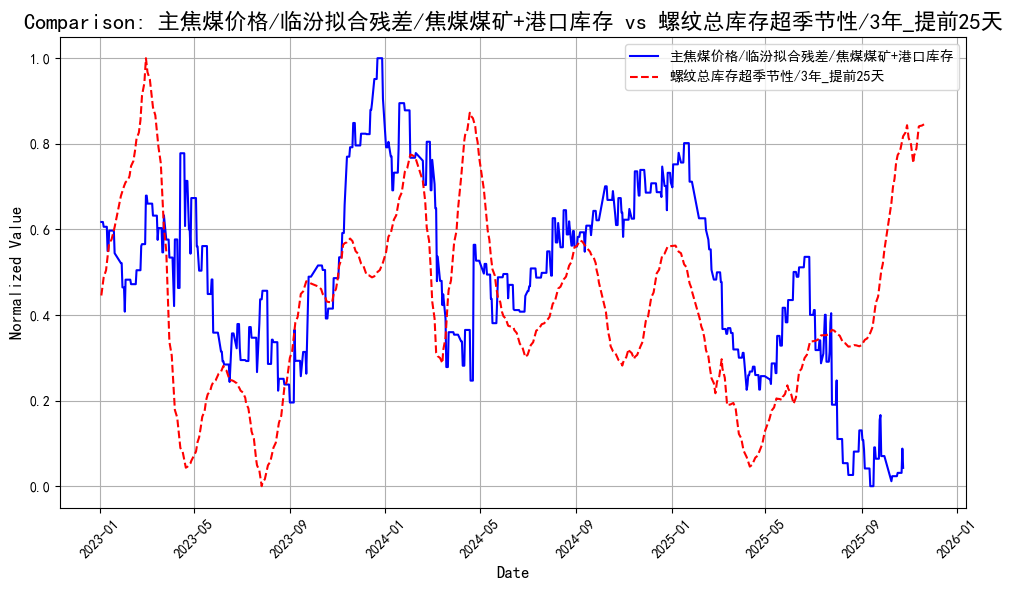

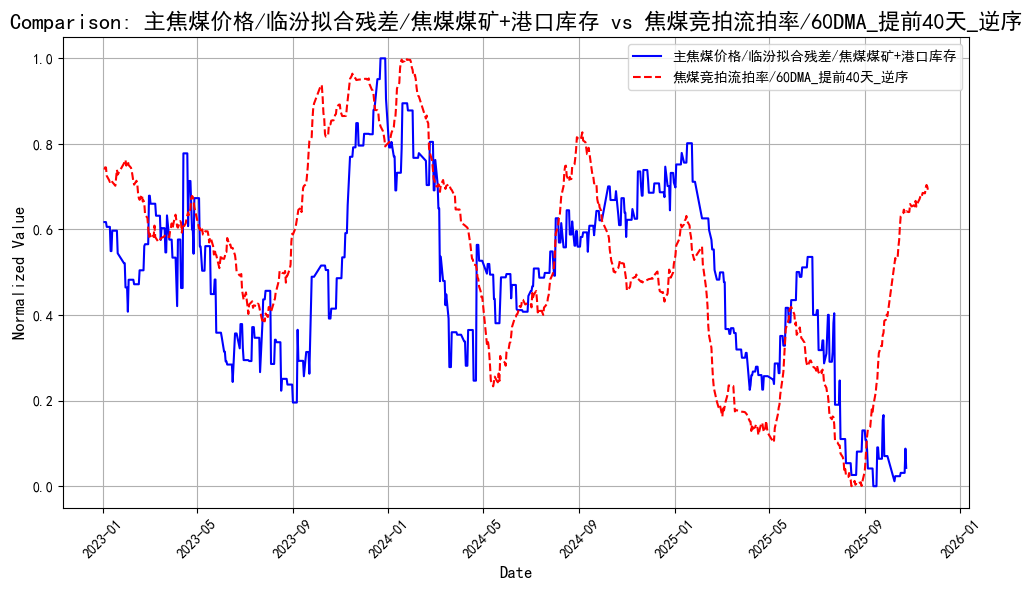

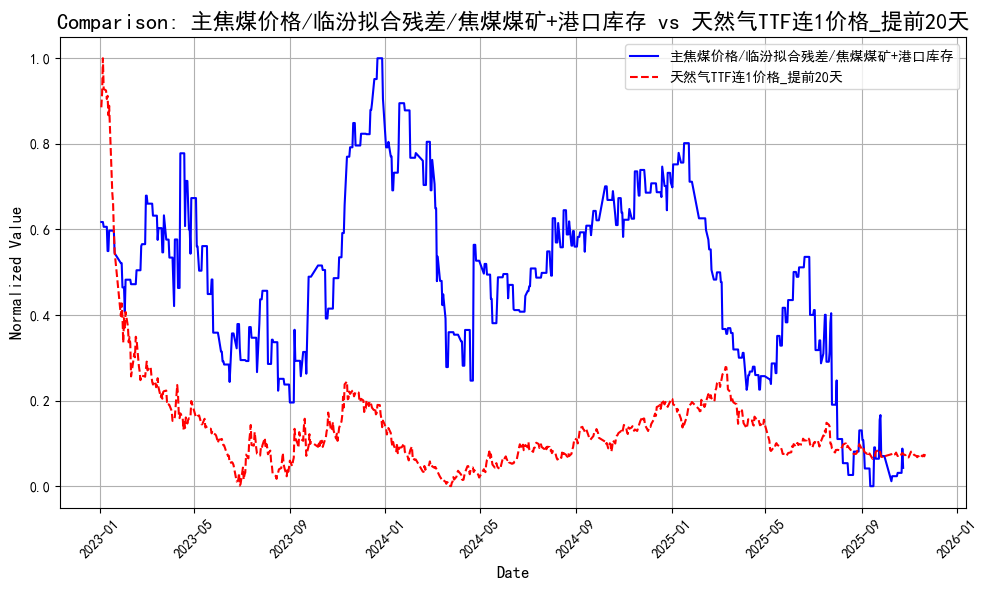

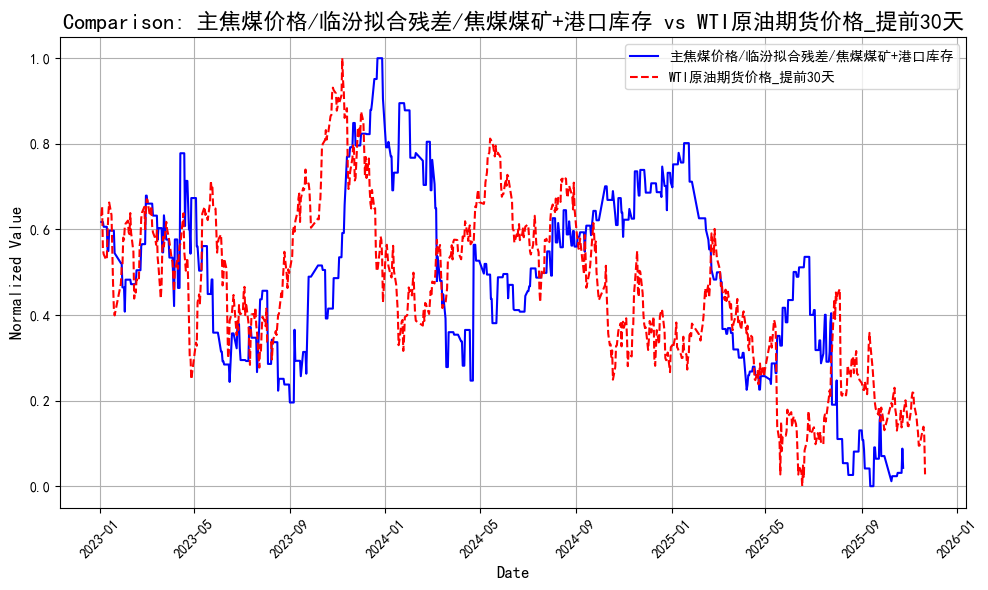

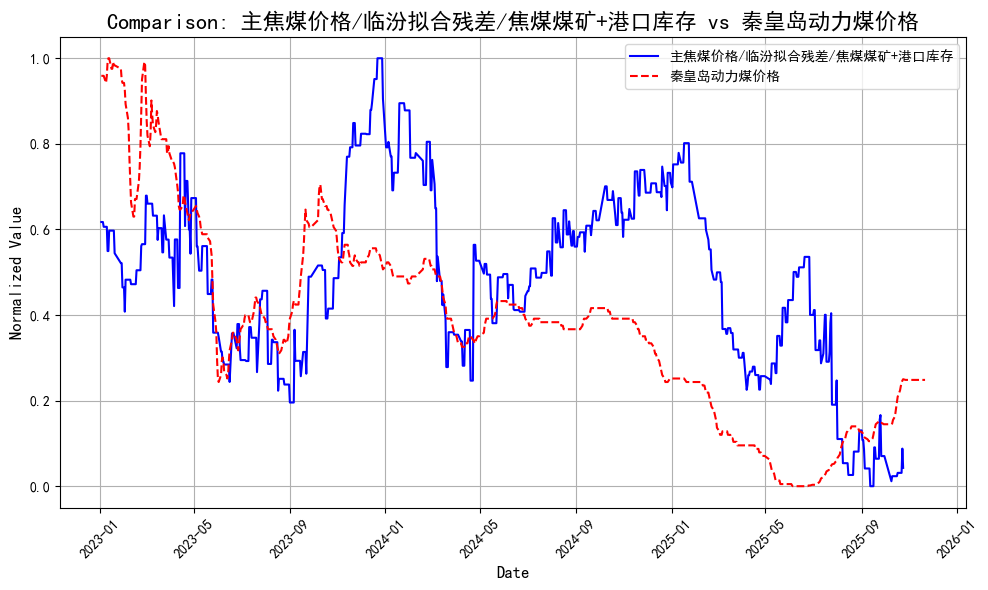

In [9]:
################################# X 和 Y 对比 观察领先性 #################################
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存', 
    compare_cols=[
        '焦煤上游总库存/4WMANon-Trend/F0.1_提前20天_逆序',
        '螺纹总库存超季节性/3年_提前25天',
        '焦煤竞拍流拍率/60DMA_提前40天_逆序',
        '天然气TTF连1价格_提前20天',
        'WTI原油期货价格_提前30天',
        '秦皇岛动力煤价格',
       ]
)

In [10]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 10
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '焦煤上游总库存/4WMANon-Trend/F0.1_提前20天_逆序',
#        '螺纹总库存超季节性/3年_提前25天',
        '焦煤竞拍流拍率/60DMA_提前40天_逆序',
        '天然气TTF连1价格_提前20天',
        'WTI原油期货价格_提前30天',
        '秦皇岛动力煤价格',
]

predict_column = '主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 95)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 3.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数


params={
    'objective': 'reg:squarederror',
    'learning_rate': 0.5, 
    'max_depth': 2, 
    'min_child_weight': 1, 
    'subsample': 0.8, 
    'colsample_bytree': 0.9, 
    'gamma': 0.2, 
    'reg_alpha': 0.1, 
    'reg_lambda': 1.5,     
    'eval_metric': 'rmse', 
    'seed': 42 ,
    'booster': 'gblinear'  # 使用线性提升器
}

num_boost_round = 300
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=50,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=10000 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:378.34987	train-rmse:155.62814


[85]	eval-rmse:388.18572	train-rmse:149.16479


训练集 MSE (DMatrix): 22671.8716, 训练集 R² (DMatrix): 0.3239
测试集 MSE (DMatrix): 150688.168, 测试集 R² (DMatrix): -560.5069


C:\Users\Hz\miniconda3\envs\myenv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [15:51:31] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  self.starting_round = model.num_boosted_rounds()


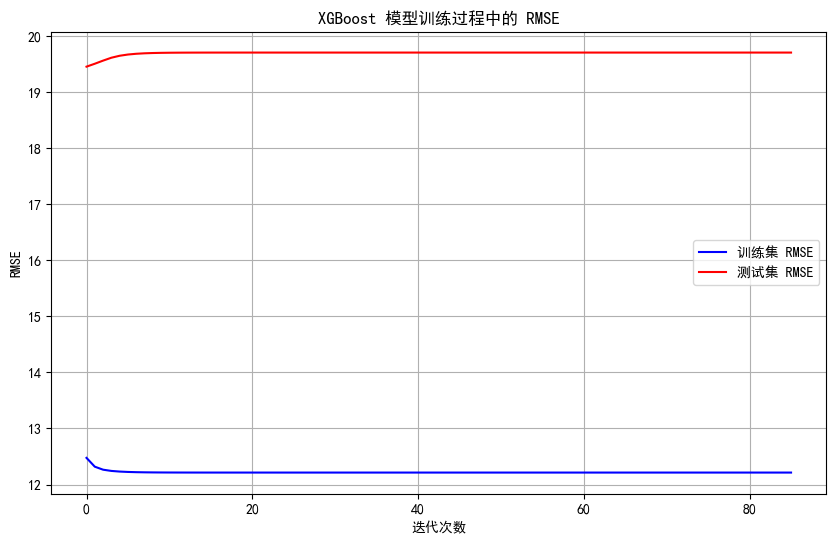

In [11]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=50,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:161.87913


[85]	train-rmse:156.24990


全部数据 MSE: 24414.0323, 全部数据 R²: 0.3095


C:\Users\Hz\miniconda3\envs\myenv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [15:51:31] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  self.starting_round = model.num_boosted_rounds()


Gap between last actual value and first prediction: -375.38906634521487


"\n# 反转预测值_全量的斜率\n#last_value = future_data['预测值_全量'].iloc[0]\n#slope = (future_data['预测值_全量'].iloc[-1] - future_data['预测值_全量'].iloc[0]) / (len(future_data) - 1)\n#future_data['预测值_全量'] = last_value - slope * np.arange(len(future_data))\n\nplt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')\n\n# 添加分割线\nplt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')\nplt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')\n\n# 设置标题和图例\nplt.title('主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

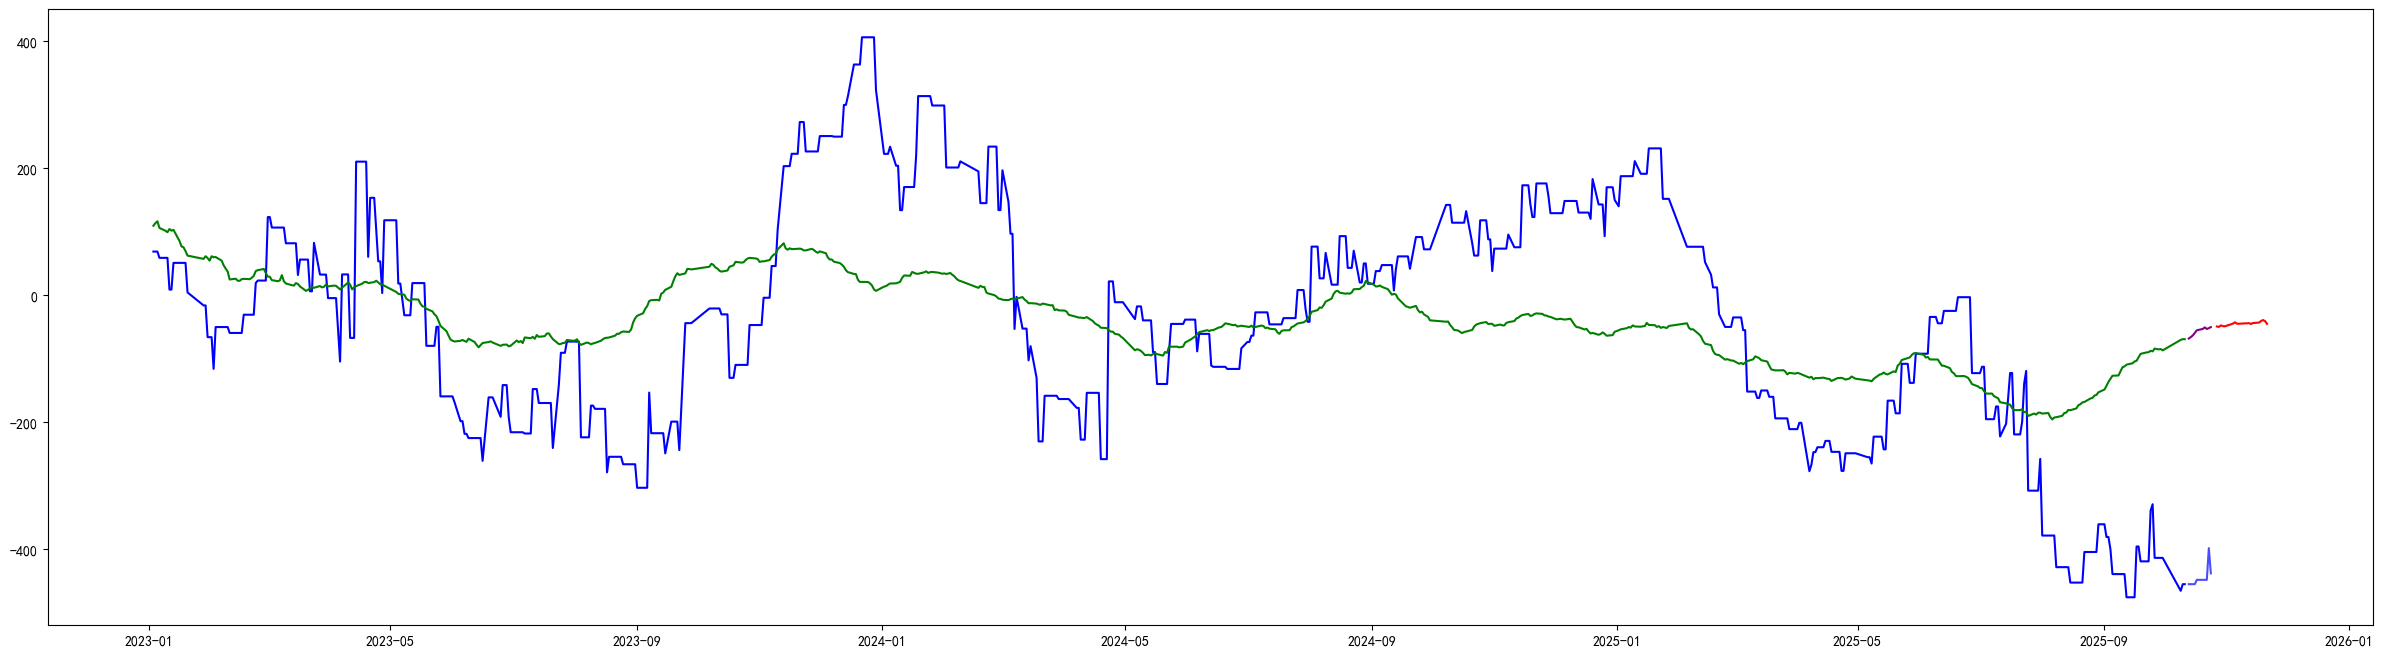

In [13]:
################################# 可视化 #################################


# 创建一个新的图形
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
'''
# 反转预测值_全量的斜率
#last_value = future_data['预测值_全量'].iloc[0]
#slope = (future_data['预测值_全量'].iloc[-1] - future_data['预测值_全量'].iloc[0]) / (len(future_data) - 1)
#future_data['预测值_全量'] = last_value - slope * np.arange(len(future_data))

plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存')
plt.legend()
plt.grid(True)
plt.show()
'''


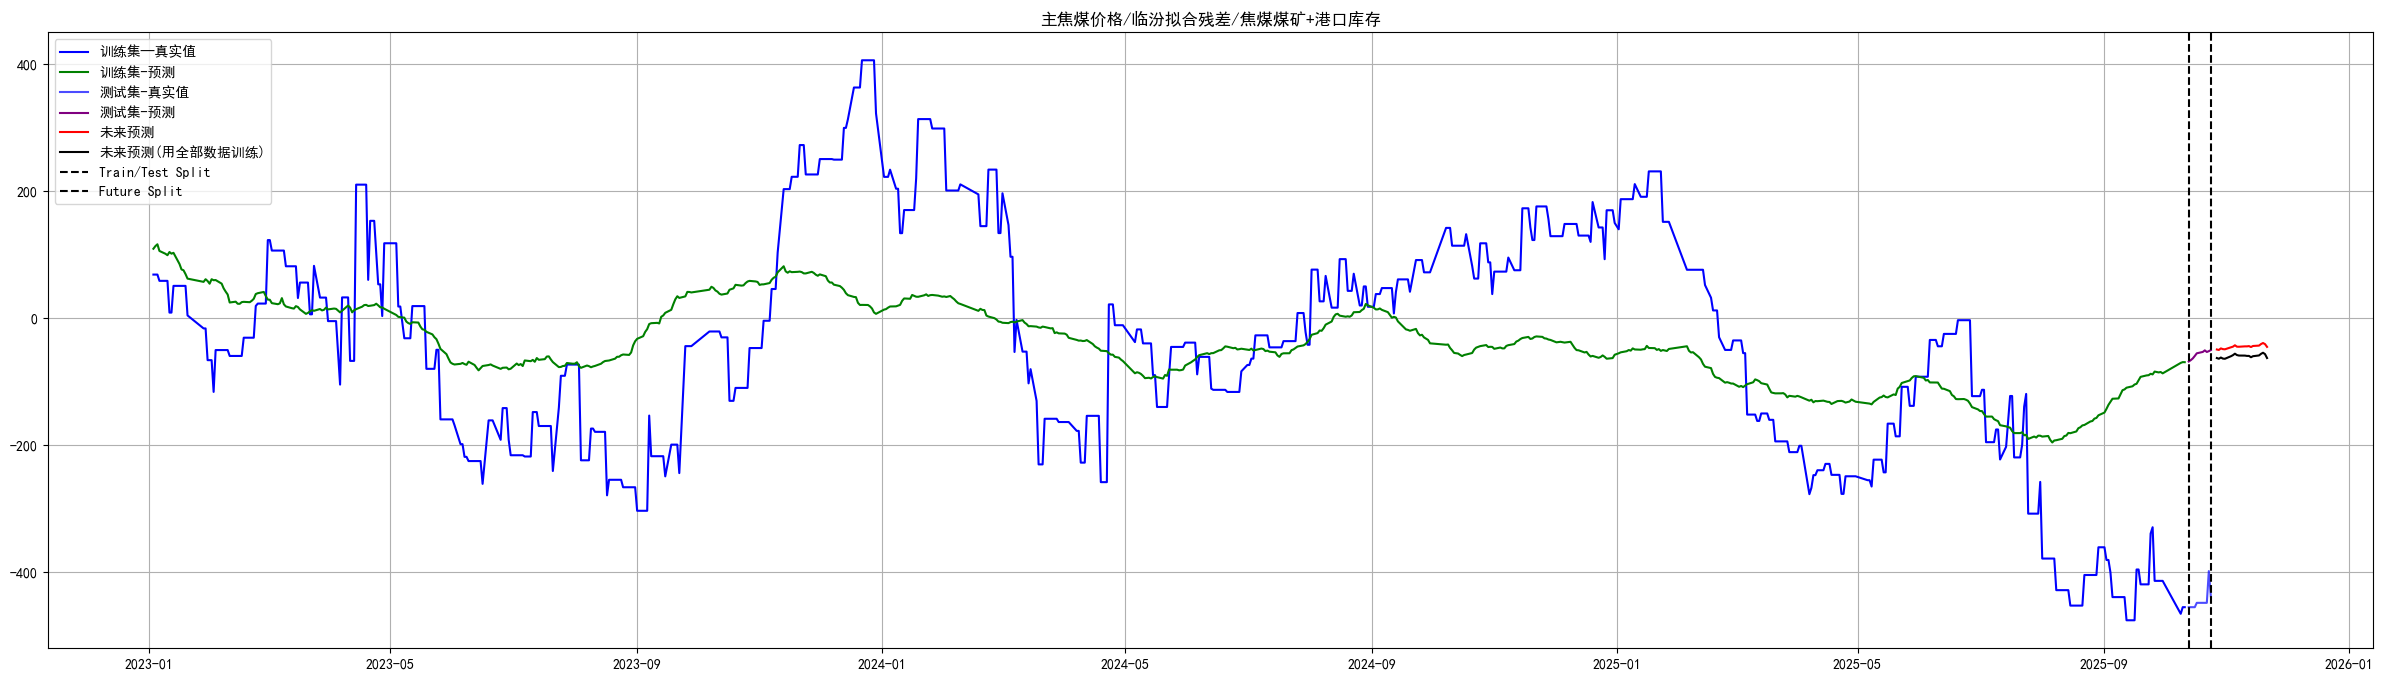

In [14]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
#future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')


# 设置标题和图例
plt.title('主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存')   
plt.legend()
plt.grid(True)
plt.show()


In [15]:
#plot_xgb_feature_importance(model_all, X_train)

---

In [16]:
################################# 训练预测数据 excel格式输出  #################################

############ 日度 数据 ############
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})

historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})

merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/主焦煤价格-临汾拟合残差-焦煤煤矿+港口库存_合并数据.xlsx', index=False,float_format='%.4f')

############ 月度 数据 ############
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
test_pred_2024 = test_data[['Date', '预测值']].copy()
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/主焦煤价格-临汾拟合残差-焦煤煤矿+港口库存_月度数据.xlsx', index=False,float_format= '%.4f')

In [17]:
merged_df_daily.head()

,Date,真实值,预测值
719,2025/11/21,NaN,-62.463776
718,2025/11/20,NaN,-56.314793
717,2025/11/19,NaN,-54.127777
716,2025/11/18,NaN,-55.872940
715,2025/11/17,NaN,-58.414703


---

In [18]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.焦煤_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [19]:
from Lcel import update_excel_data
file_path = "eta/1.焦煤_数据上传.xlsx"
sheet_name = "详情页"
identifier = "主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [20]:
'''
# 定义参数网格
param_grid = {
    'learning_rate': [0.01, 0.05, 0.09],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1, 1.5]
}

# 固定参数
fixed_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42
}

# 使用网格搜索找到最佳参数
best_rmse = float('inf')
best_params = {}

# 从参数网格中随机选择一些组合进行测试（完整网格搜索可能太耗时）
import random
param_combinations = 100  # 测试的参数组合数量
tested_combinations = 0

while tested_combinations < param_combinations:
    # 随机选择参数组合
    current_params = {
        'learning_rate': random.choice(param_grid['learning_rate']),
        'max_depth': random.choice(param_grid['max_depth']),
        'min_child_weight': random.choice(param_grid['min_child_weight']),
        'subsample': random.choice(param_grid['subsample']),
        'colsample_bytree': random.choice(param_grid['colsample_bytree']),
        'gamma': random.choice(param_grid['gamma']),
        'reg_alpha': random.choice(param_grid['reg_alpha']),
        'reg_lambda': random.choice(param_grid['reg_lambda'])
    }
    
    # 合并固定参数
    current_params.update(fixed_params)
    
    # 使用交叉验证评估当前参数
    cv_results = xgb.cv(
        current_params,
        train_dmatrix_huber,
        num_boost_round=100,
        nfold=3,
        early_stopping_rounds=20,
        verbose_eval=False
    )
    
    # 获取最佳RMSE
    current_rmse = cv_results['test-rmse-mean'].min()
    
    # 更新最佳参数
    if current_rmse < best_rmse:
        best_rmse = current_rmse
        best_params = current_params
    
    tested_combinations += 1

# 使用找到的最佳参数
params = best_params
print(f"最佳参数: {params}")
print(f"最佳RMSE: {best_rmse}")
'''

'\n# 定义参数网格\nparam_grid = {\n    \'learning_rate\': [0.01, 0.05, 0.09],\n    \'max_depth\': [3, 5, 7],\n    \'min_child_weight\': [1, 3, 5],\n    \'subsample\': [0.7, 0.8, 0.9],\n    \'colsample_bytree\': [0.7, 0.8, 0.9],\n    \'gamma\': [0, 0.1, 0.2],\n    \'reg_alpha\': [0, 0.1, 0.5],\n    \'reg_lambda\': [0.5, 1, 1.5]\n}\n\n# 固定参数\nfixed_params = {\n    \'objective\': \'reg:squarederror\',\n    \'eval_metric\': \'rmse\',\n    \'seed\': 42\n}\n\n# 使用网格搜索找到最佳参数\nbest_rmse = float(\'inf\')\nbest_params = {}\n\n# 从参数网格中随机选择一些组合进行测试（完整网格搜索可能太耗时）\nimport random\nparam_combinations = 100  # 测试的参数组合数量\ntested_combinations = 0\n\nwhile tested_combinations < param_combinations:\n    # 随机选择参数组合\n    current_params = {\n        \'learning_rate\': random.choice(param_grid[\'learning_rate\']),\n        \'max_depth\': random.choice(param_grid[\'max_depth\']),\n        \'min_child_weight\': random.choice(param_grid[\'min_child_weight\']),\n        \'subsample\': random.choice(param_grid[\'subsample